In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd # Essential for maps
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
import warnings
import os

# ================================================
# 1. DATA INITIALIZATION & GEOSPATIAL CONFIGURATION
# ================================================
# Load processed dataset and initialize high-resolution world map shapefiles
# for downstream geospatial visualization. Includes country name standardization.

INPUT_PATH = '../data/cleaned_data_final.csv'

# Load Data
df = pd.read_csv(INPUT_PATH)

os.makedirs('../images/04_geospatial', exist_ok=True)

# To avoid the GeoPandas 1.0 internal dataset deprecation error, we download directly from URL.
print("Downloading World Map Data (Natural Earth)...")
try:
    # Fetch country borders (low resolution) from Natural Earth
    url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)
    
    # Standardize the column name to 'name' for merging
    # The downloaded file typically has 'ADMIN' or 'NAME'.
    if 'ADMIN' in world.columns:
        world = world.rename(columns={'ADMIN': 'name'})
    elif 'NAME' in world.columns:
        world = world.rename(columns={'NAME': 'name'})
        
    # Keep only necessary columns to save memory
    world = world[['name', 'geometry']]
    
except Exception as e:
    print(f"Map download failed. Error: {e}")
    # Create an empty frame if offline so the code doesn't crash 
    world = gpd.GeoDataFrame()

# Map EM-DAT country names to Natural Earth names
# This mapping is critical for the Choropleth map
country_corrections = {
    'United States of America': 'United States of America',
    'Türkiye': 'Turkey', 
    'China': 'China',
    'Russian Federation': 'Russia',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Iran (Islamic Republic of)': 'Iran',
    'Syrian Arab Republic': 'Syria',
    'Republic of Korea': 'South Korea',
    'Democratic Republic of the Congo': 'Democratic Republic of the Congo', 
    'United Republic of Tanzania': 'Tanzania'
}

df['country_mapped'] = df['country'].replace(country_corrections)

# Design Settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['figure.dpi'] = 150
sns.set_style("white") # Maps look better without grid lines on white background

print("Setup Complete. World Map Loaded.")

Setup Complete. World Map Loaded.


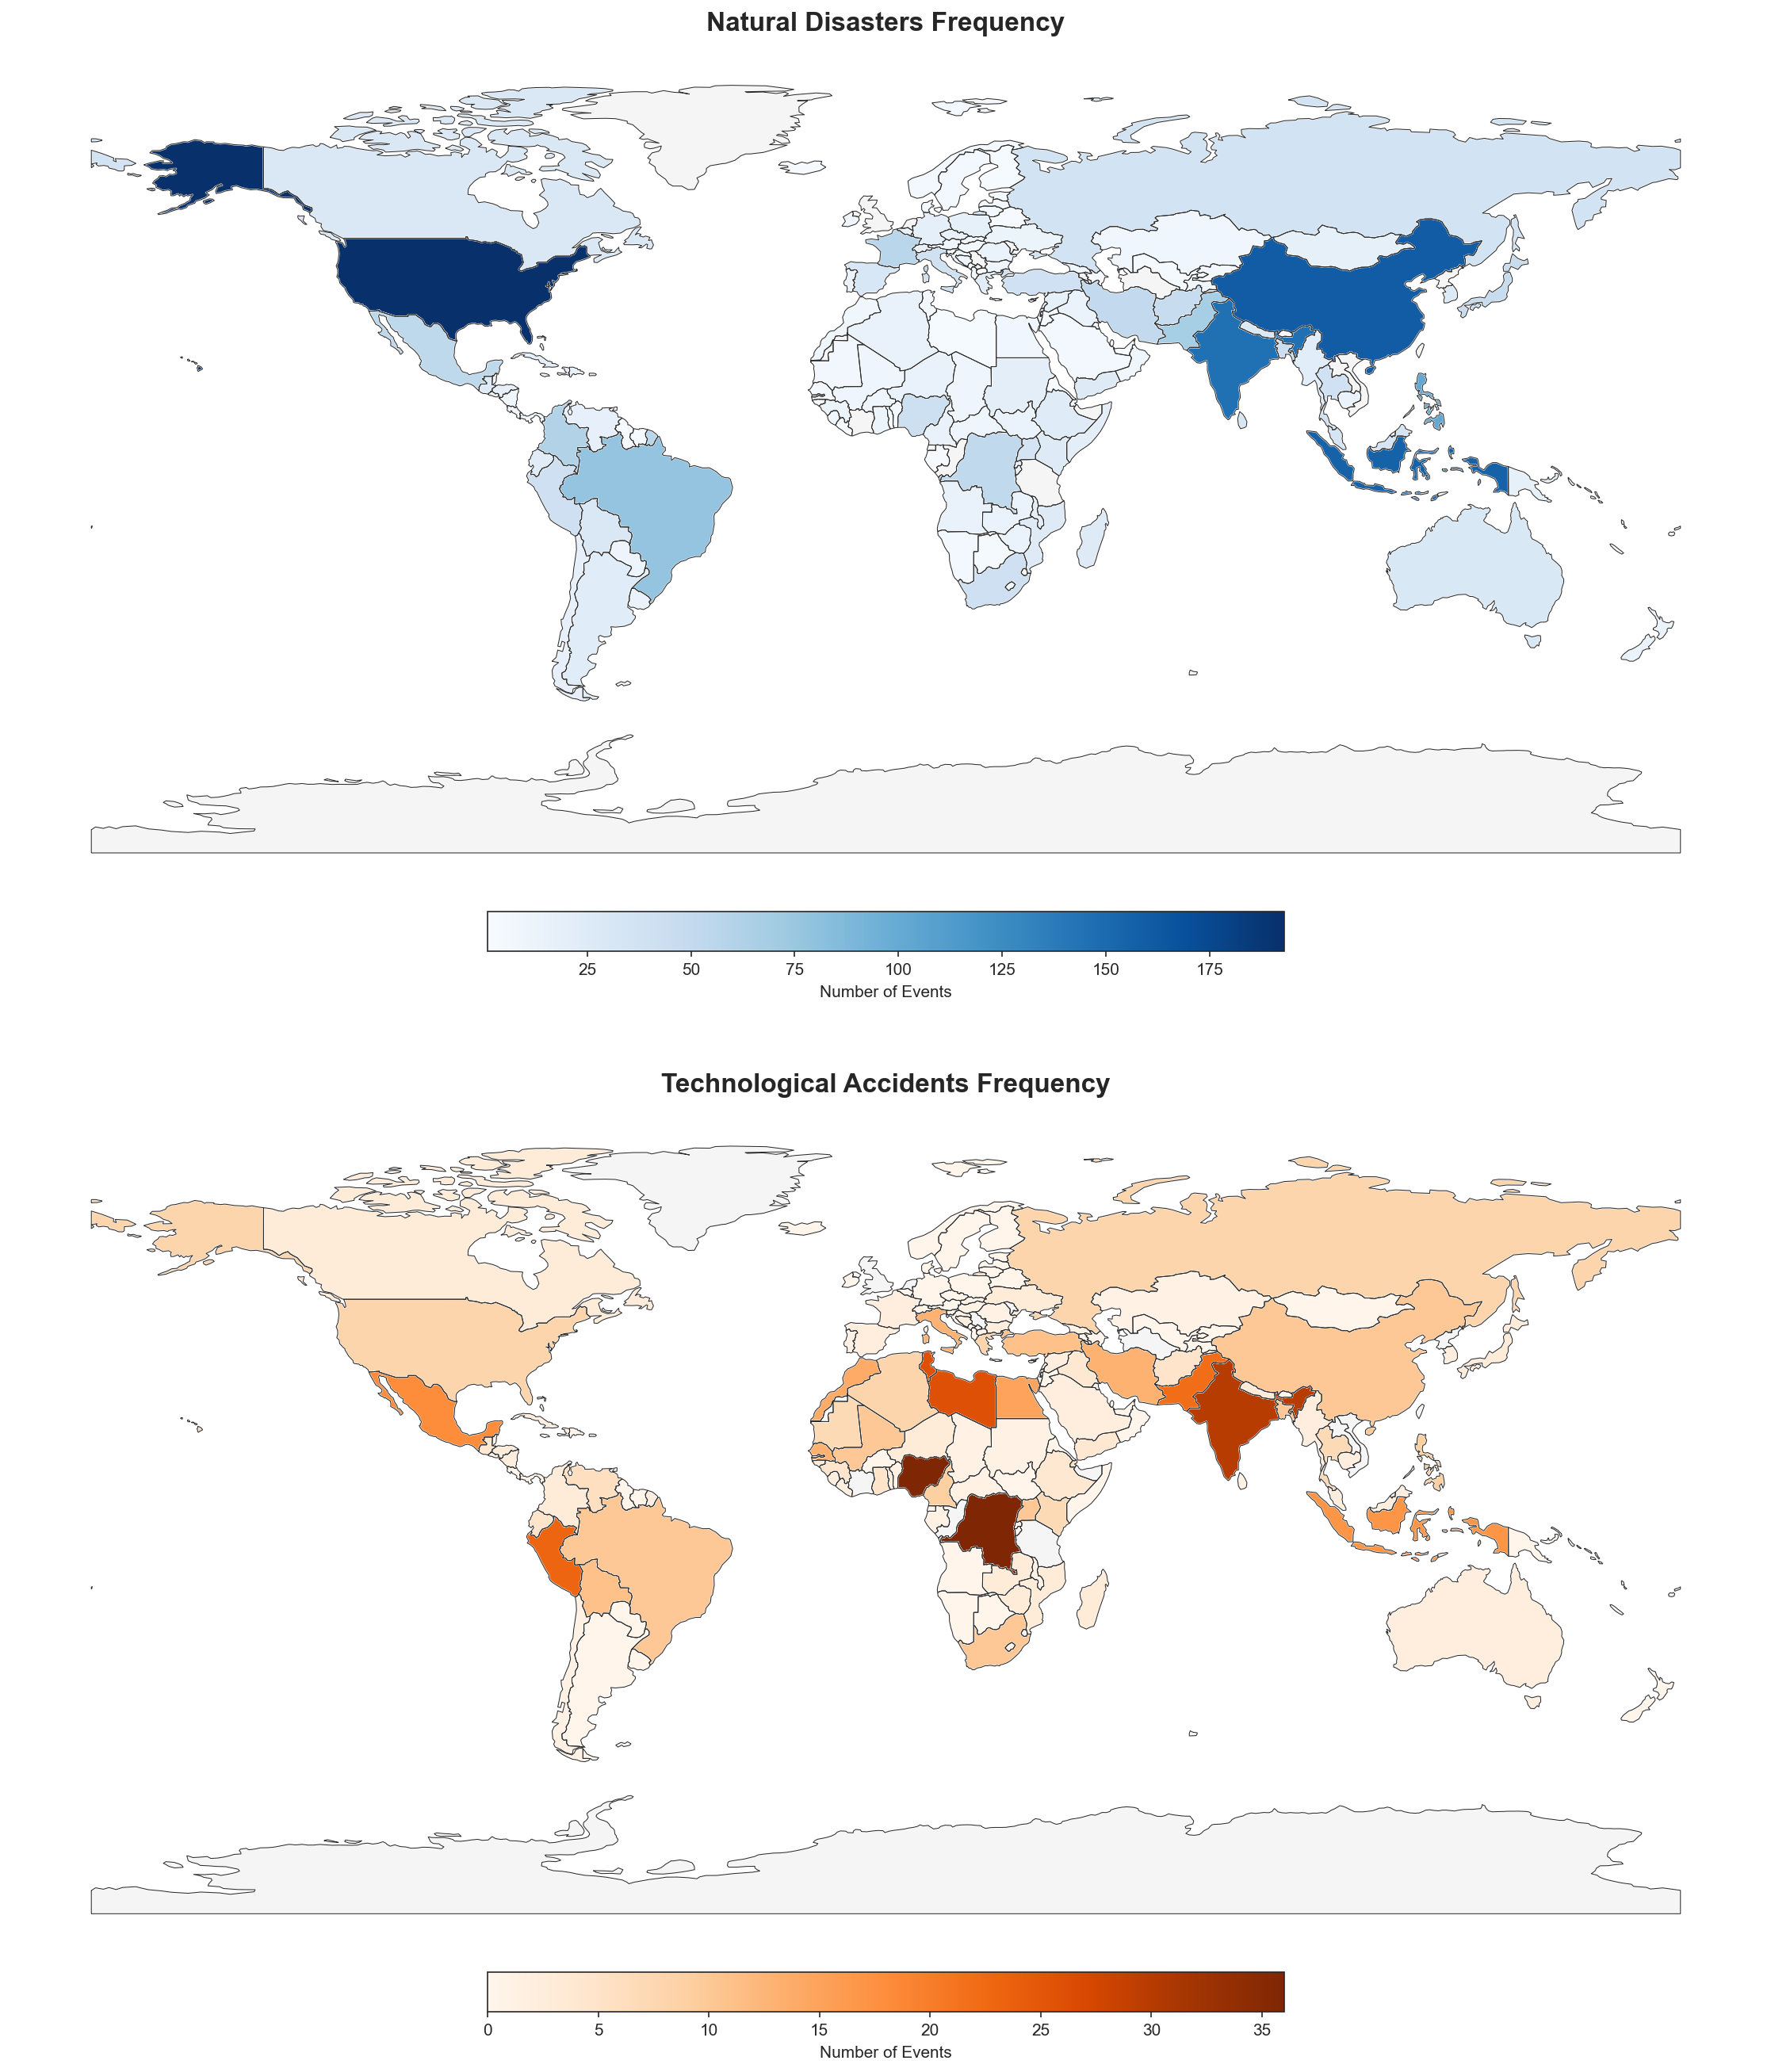

In [2]:
# ==========================================
# 2. COMPARATIVE DENSITY ANALYSIS: NATURAL HAZARDS VS. TECHNOLOGICAL INCIDENTS
# ==========================================
# Contrast the spatial frequency of climate/geological disasters against 
# human-induced technological failures (e.g., industrial accidents, transport crashes).

# 1. Data Preparation
tech_types = ['Road', 'Water', 'Transport', 'Industrial accident', 'Miscellaneous accident']
df['category'] = df['disaster_type'].apply(lambda x: 'Technological' if x in tech_types else 'Natural')
cat_counts = df.groupby(['country_mapped', 'category']).size().unstack(fill_value=0).reset_index()
world_cat = world.merge(cat_counts, left_on='name', right_on='country_mapped', how='left')

# 2. Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 18)) # Slightly reduced height

# --- TOP MAP: NATURAL DISASTERS ---
world.boundary.plot(ax=ax1, linewidth=0.5, color='#2b2b2b') # Dark grey borders
world_cat.plot(column='Natural', ax=ax1, cmap='Blues', legend=True,
               # 'pad': 0.01 -> Attach bar to map
               # 'fraction': 0.03 -> Thin bar
               legend_kwds={'label': "Number of Events", 'orientation': "horizontal", 
                            'shrink': 0.6, 'pad': 0.02, 'fraction': 0.04},
               missing_kwds={'color': '#f5f5f5'})
ax1.set_title("Natural Disasters Frequency", fontsize=16, fontweight='bold', pad=10)
ax1.set_axis_off()

# --- BOTTOM MAP: TECHNOLOGICAL ACCIDENTS ---
world.boundary.plot(ax=ax2, linewidth=0.5, color='#2b2b2b')
world_cat.plot(column='Technological', ax=ax2, cmap='Oranges', legend=True,
               legend_kwds={'label': "Number of Events", 'orientation': "horizontal", 
                            'shrink': 0.6, 'pad': 0.02, 'fraction': 0.04},
               missing_kwds={'color': '#f5f5f5'})
ax2.set_title("Technological Accidents Frequency", fontsize=16, fontweight='bold', pad=10)
ax2.set_axis_off()

plt.tight_layout()
plt.savefig('../images/04_geospatial/geo_natural_vs_tech.png', dpi=300, bbox_inches='tight')
plt.show()

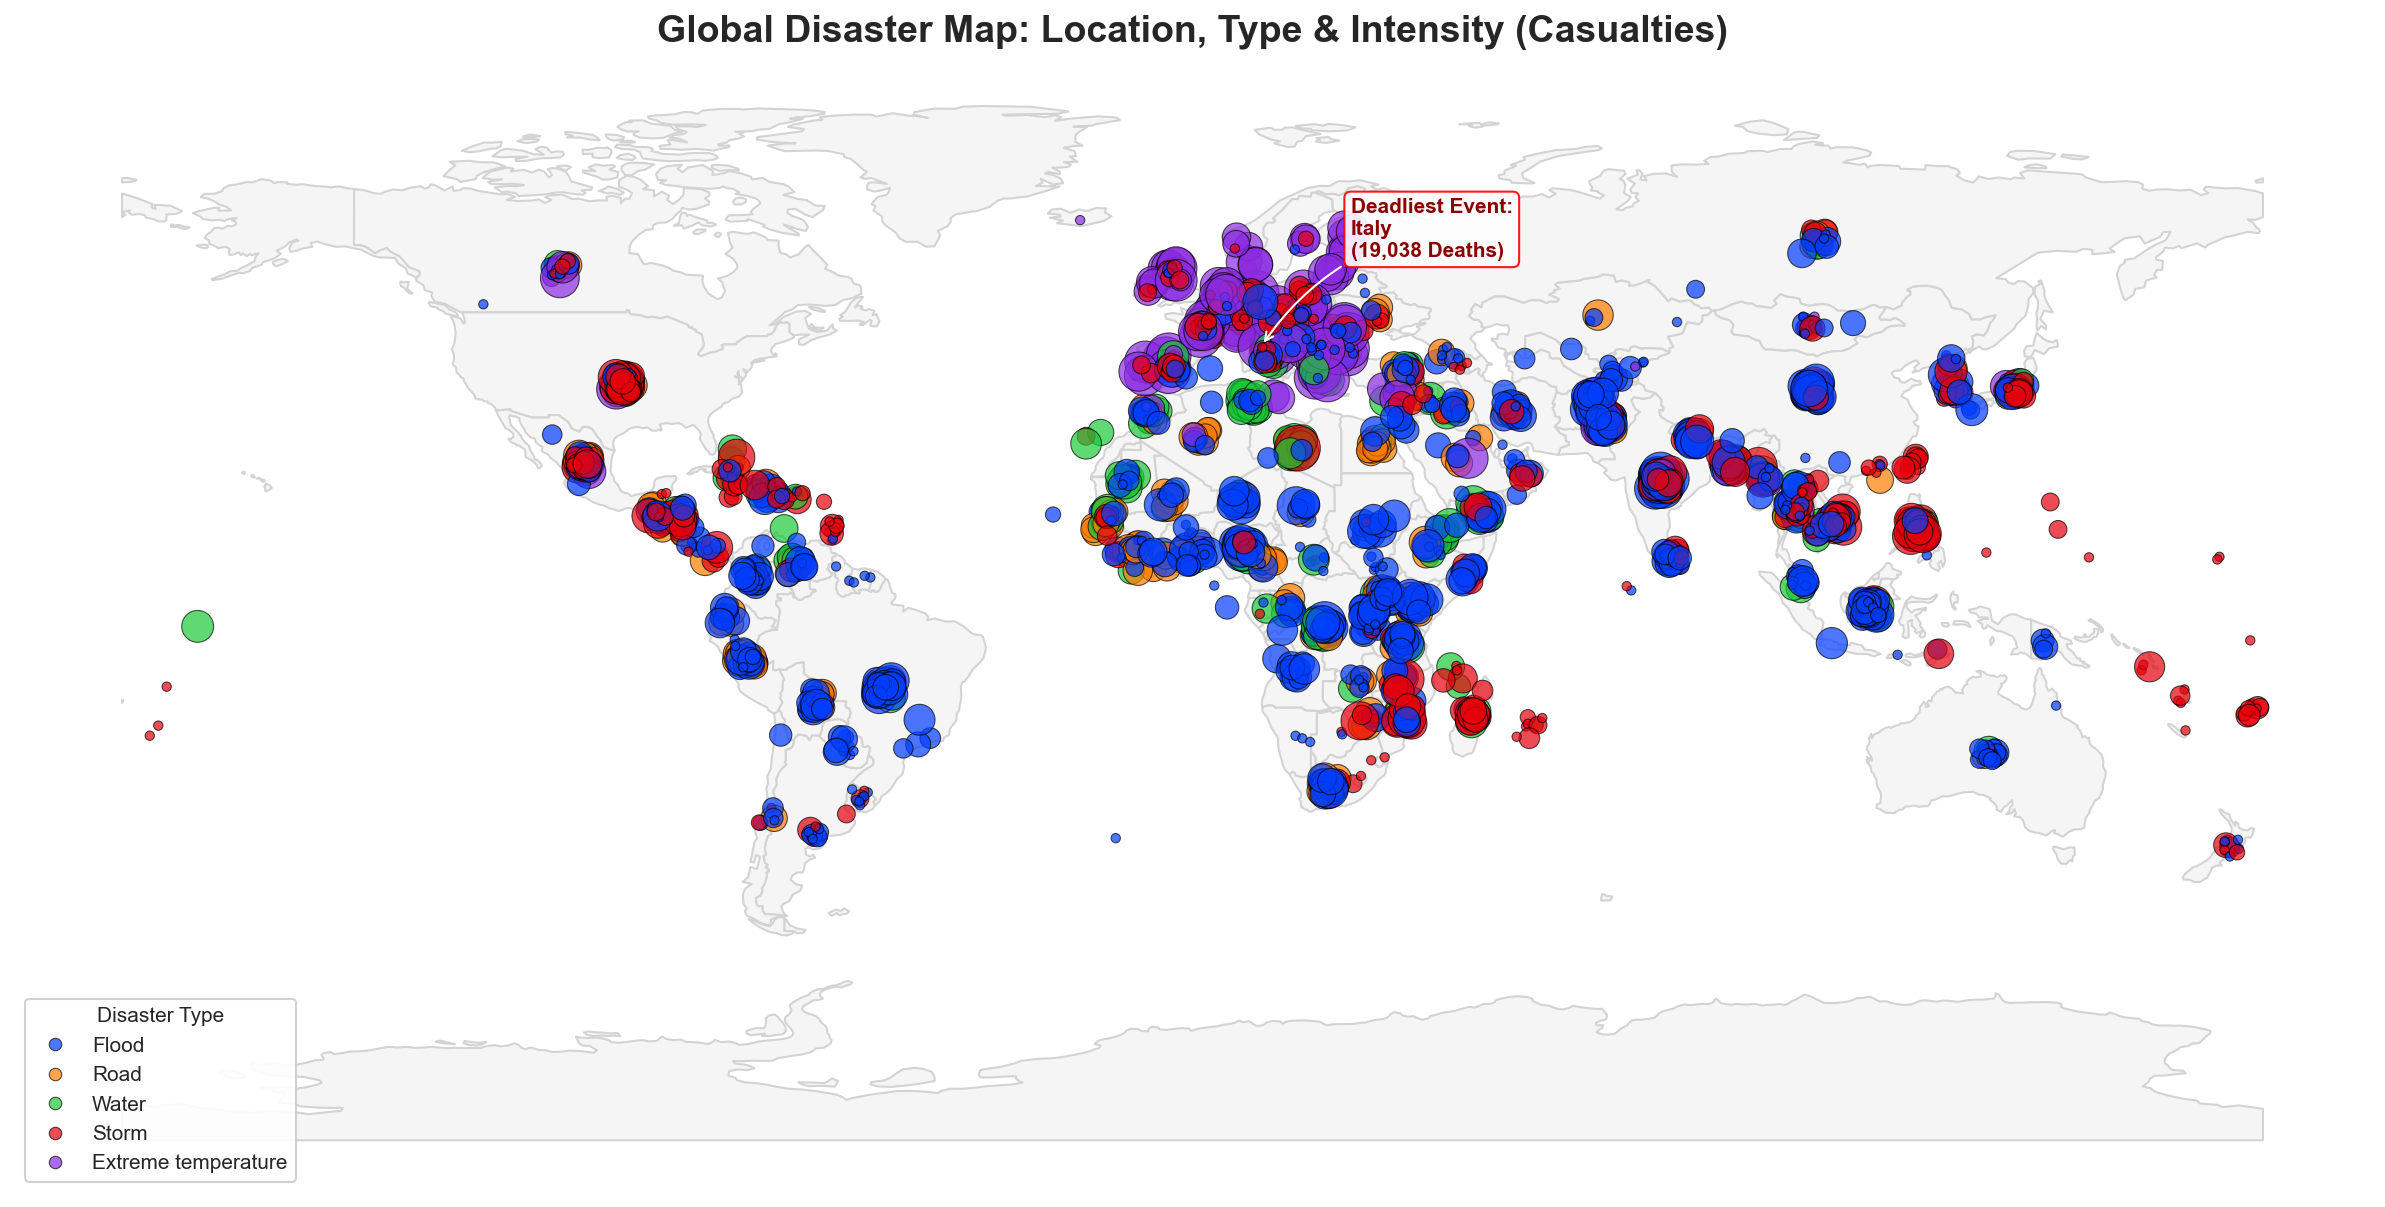

In [3]:
# ===============================================
# 3. GLOBAL CASUALTY DISTRIBUTION & EVENT INTENSITY
# ===============================================
# Visualize exact event locations with point size correlated to fatality 
# counts (Casualties), highlighting high-lethality zones globally.

# Filter only rows with coordinates
geo_df = df.dropna(subset=['latitude', 'longitude'])

# Focus on Top 5 types to avoid clutter
top_types_geo = geo_df['disaster_type'].value_counts().head(5).index
geo_df_filtered = geo_df[geo_df['disaster_type'].isin(top_types_geo)]

fig, ax = plt.subplots(figsize=(16, 10))

# 1. Base Map (World - Grey)
world.plot(ax=ax, color='whitesmoke', edgecolor='lightgray')

# 2. Scatter Plot (Points)
# Size: Casualties (Logarithmic scale to handle outliers)
sizes = np.log1p(geo_df_filtered['casualties']) * 20 + 10 

sns.scatterplot(data=geo_df_filtered, x='longitude', y='latitude', 
                hue='disaster_type', size=sizes, sizes=(20, 500), 
                palette='bright', alpha=0.7, ax=ax, edgecolor='black', linewidth=0.5)

# 3. Annotation (Find Deadliest Event)
deadliest_idx = geo_df_filtered['casualties'].idxmax()
deadliest = geo_df_filtered.loc[deadliest_idx]

ax.annotate(f"Deadliest Event:\n{deadliest['country']}\n({int(deadliest['casualties']):,} Deaths)", 
            xy=(deadliest['longitude'], deadliest['latitude']), 
            xytext=(deadliest['longitude'] + 15, deadliest['latitude'] + 15),
            arrowprops=dict(facecolor='red', arrowstyle="->", connectionstyle="arc3,rad=.2"),
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.9),
            fontsize=10, fontweight='bold', color='darkred')

# Legend Settings
handles, labels = ax.get_legend_handles_labels()
# Remove size legend (confusing), keep only color (type)
ax.legend(handles=handles[1:6], labels=labels[1:6], title="Disaster Type", 
          loc='lower left', frameon=True, fancybox=True, framealpha=0.9)

ax.set_title("Global Disaster Map: Location, Type & Intensity (Casualties)", fontsize=18, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.savefig('../images/04_geospatial/geo_casualties_bubble.png', dpi=300, bbox_inches='tight')
plt.show()

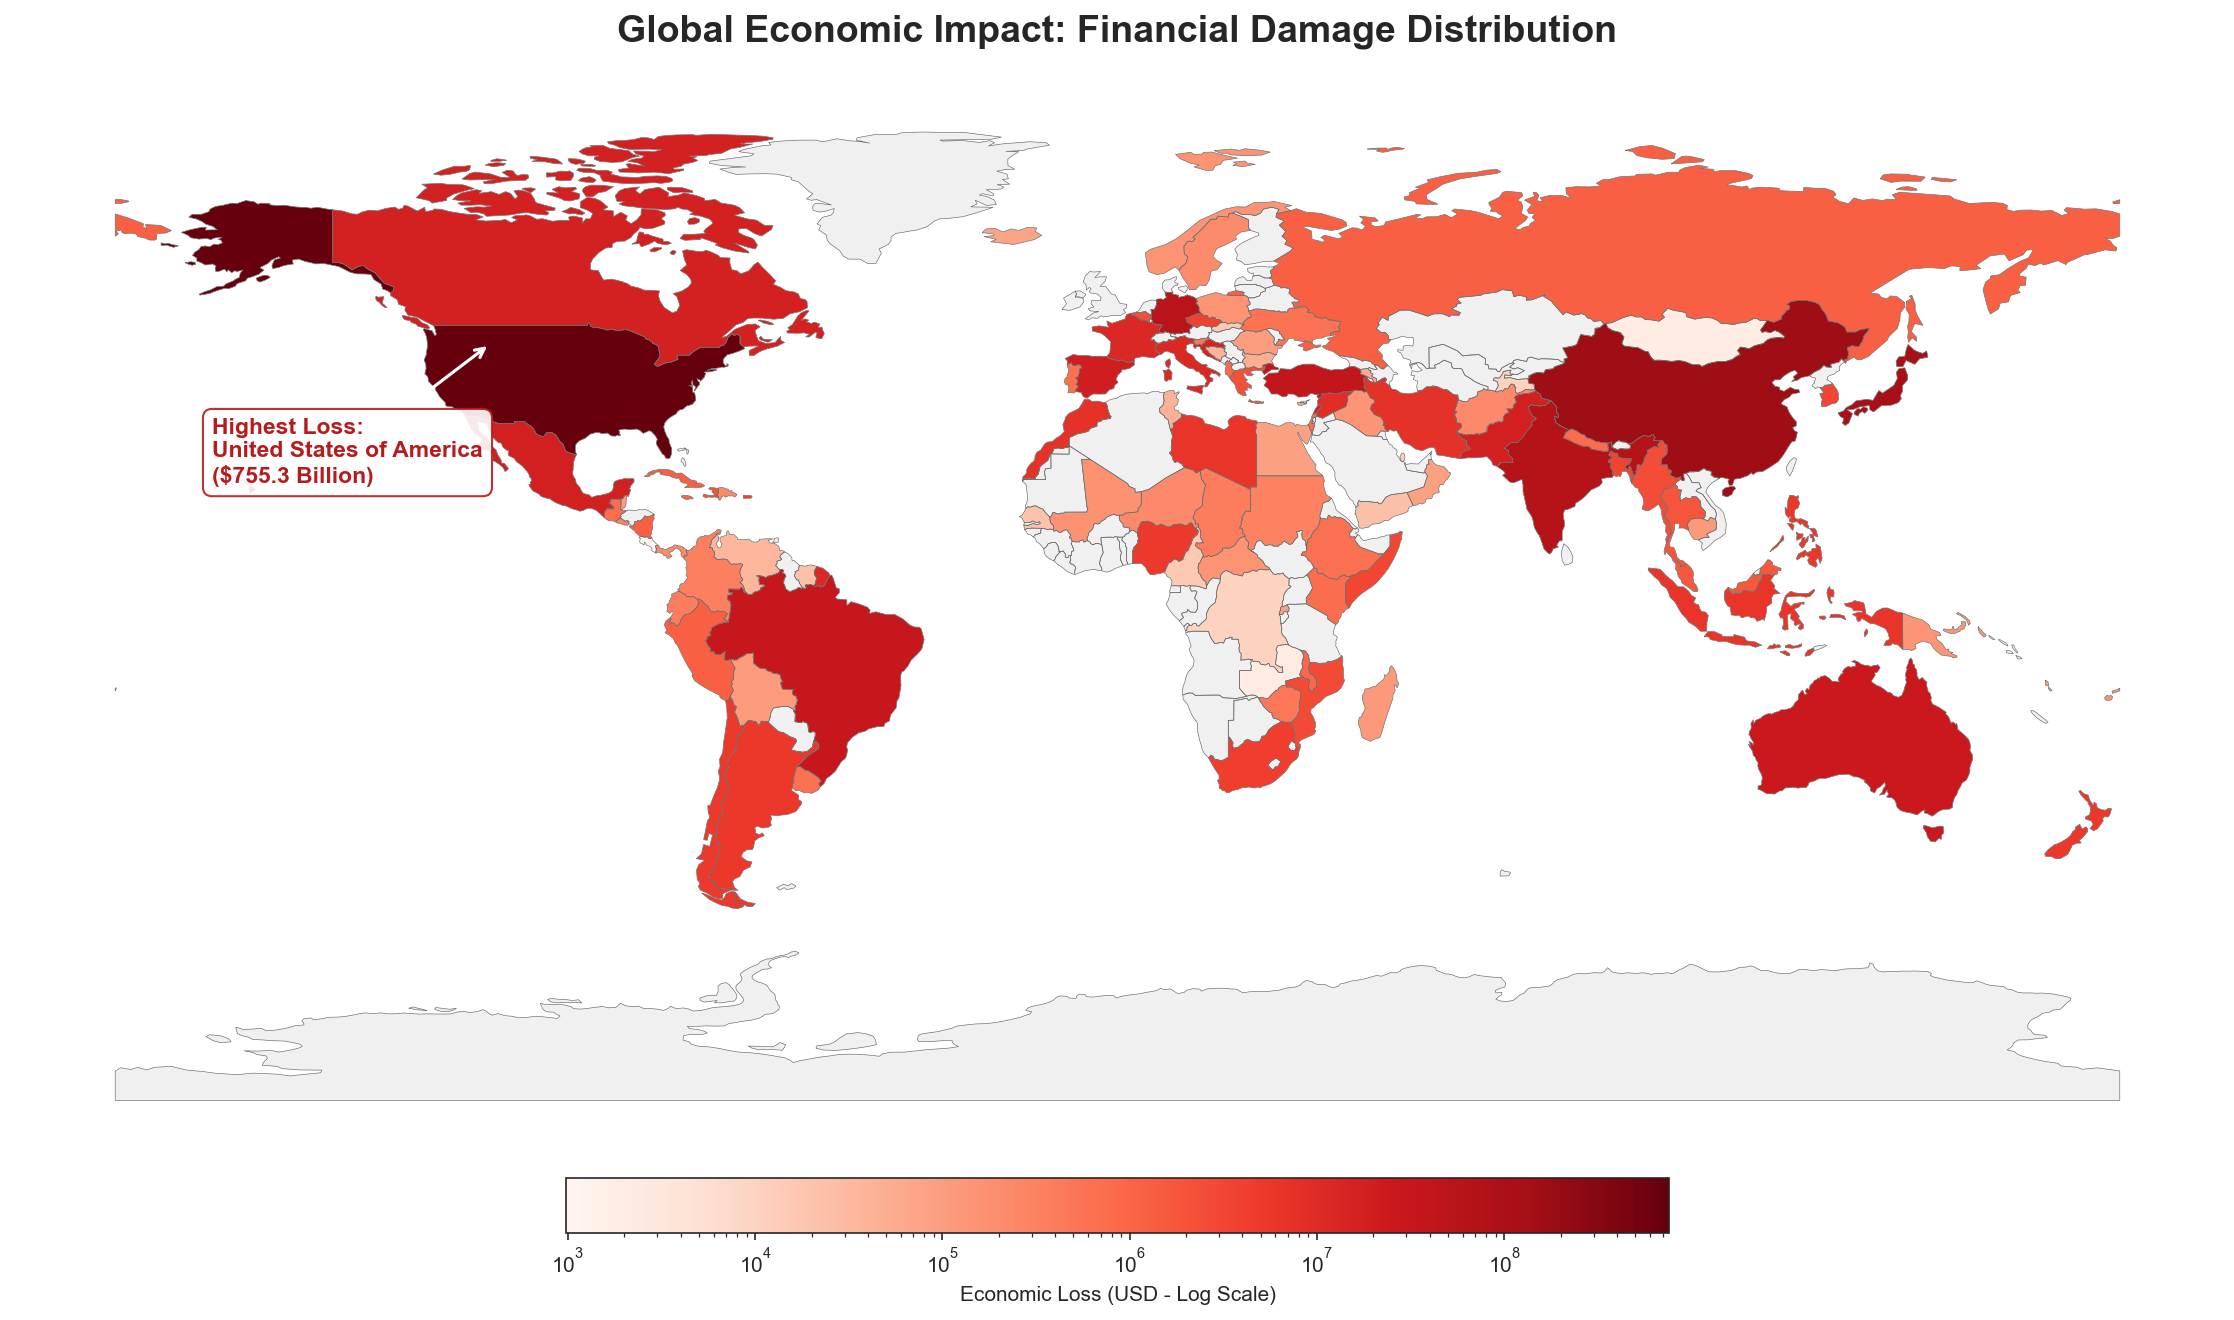

In [4]:
# ================================================================
# 4. FINANCIAL IMPACT ASSESSMENT: GLOBAL ECONOMIC LOSS DISTRIBUTION
# ================================================================
# Identify countries with the highest cumulative financial damages. A logarithmic scale
# is applied to address the high variance between developed and developing economies.

# Temporarily ignore warning
warnings.filterwarnings("ignore", category=UserWarning)

# 1. Data Preparation
country_econ = df.groupby('country_mapped')['economic_loss_usd'].sum().reset_index()
world_econ = world.merge(country_econ, left_on='name', right_on='country_mapped', how='left')
# Replace 0 with NaN
world_econ['plot_val'] = world_econ['economic_loss_usd'].replace(0, np.nan)

# 2. Visualization
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Vmin Vmax calculation
vmin = world_econ['plot_val'].min()
vmax = world_econ['plot_val'].max()

# LAYER 1: Color Fill (With Anti-Aliasing)
world_econ.plot(column='plot_val', ax=ax, legend=True,
                legend_kwds={'label': "Economic Loss (USD - Log Scale)",
                             'orientation': "horizontal", 'shrink': 0.5, 'pad': 0.02},
                cmap='Reds',
                norm=LogNorm(vmin=vmin, vmax=vmax),
                # PIXELATION FIX:
                edgecolor='white', linewidth=0.1, 
                missing_kwds={'color': '#f0f0f0', 'label': 'No Major Loss'})

# LAYER 2: Country Borders (Cleanly drawn on top)
world.boundary.plot(ax=ax, linewidth=0.3, color='#666666', zorder=2)

# Annotation
if not country_econ.empty:
    top_loss = country_econ.loc[country_econ['economic_loss_usd'].idxmax()]
    loss_bn = top_loss['economic_loss_usd'] / 1e6 
    
    geom_data = world_econ[world_econ['name'] == top_loss['country_mapped']]
    if not geom_data.empty:
        geom = geom_data.geometry.centroid.iloc[0]
        ax.annotate(f"Highest Loss:\n{top_loss['country_mapped']}\n(${loss_bn:.1f} Billion)",
                    xy=(geom.x, geom.y), 
                    xytext=(geom.x - 50, geom.y - 25),
                    arrowprops=dict(facecolor='#b71c1c', arrowstyle="->", lw=1.5), 
                    bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="#b71c1c", alpha=0.9),
                    fontsize=11, fontweight='bold', color='#b71c1c')

ax.set_title("Global Economic Impact: Financial Damage Distribution", fontsize=18, fontweight='bold', pad=20)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('../images/04_geospatial/geo_economic_loss.png', dpi=300, bbox_inches='tight')
plt.show()
warnings.filterwarnings("default", category=UserWarning)

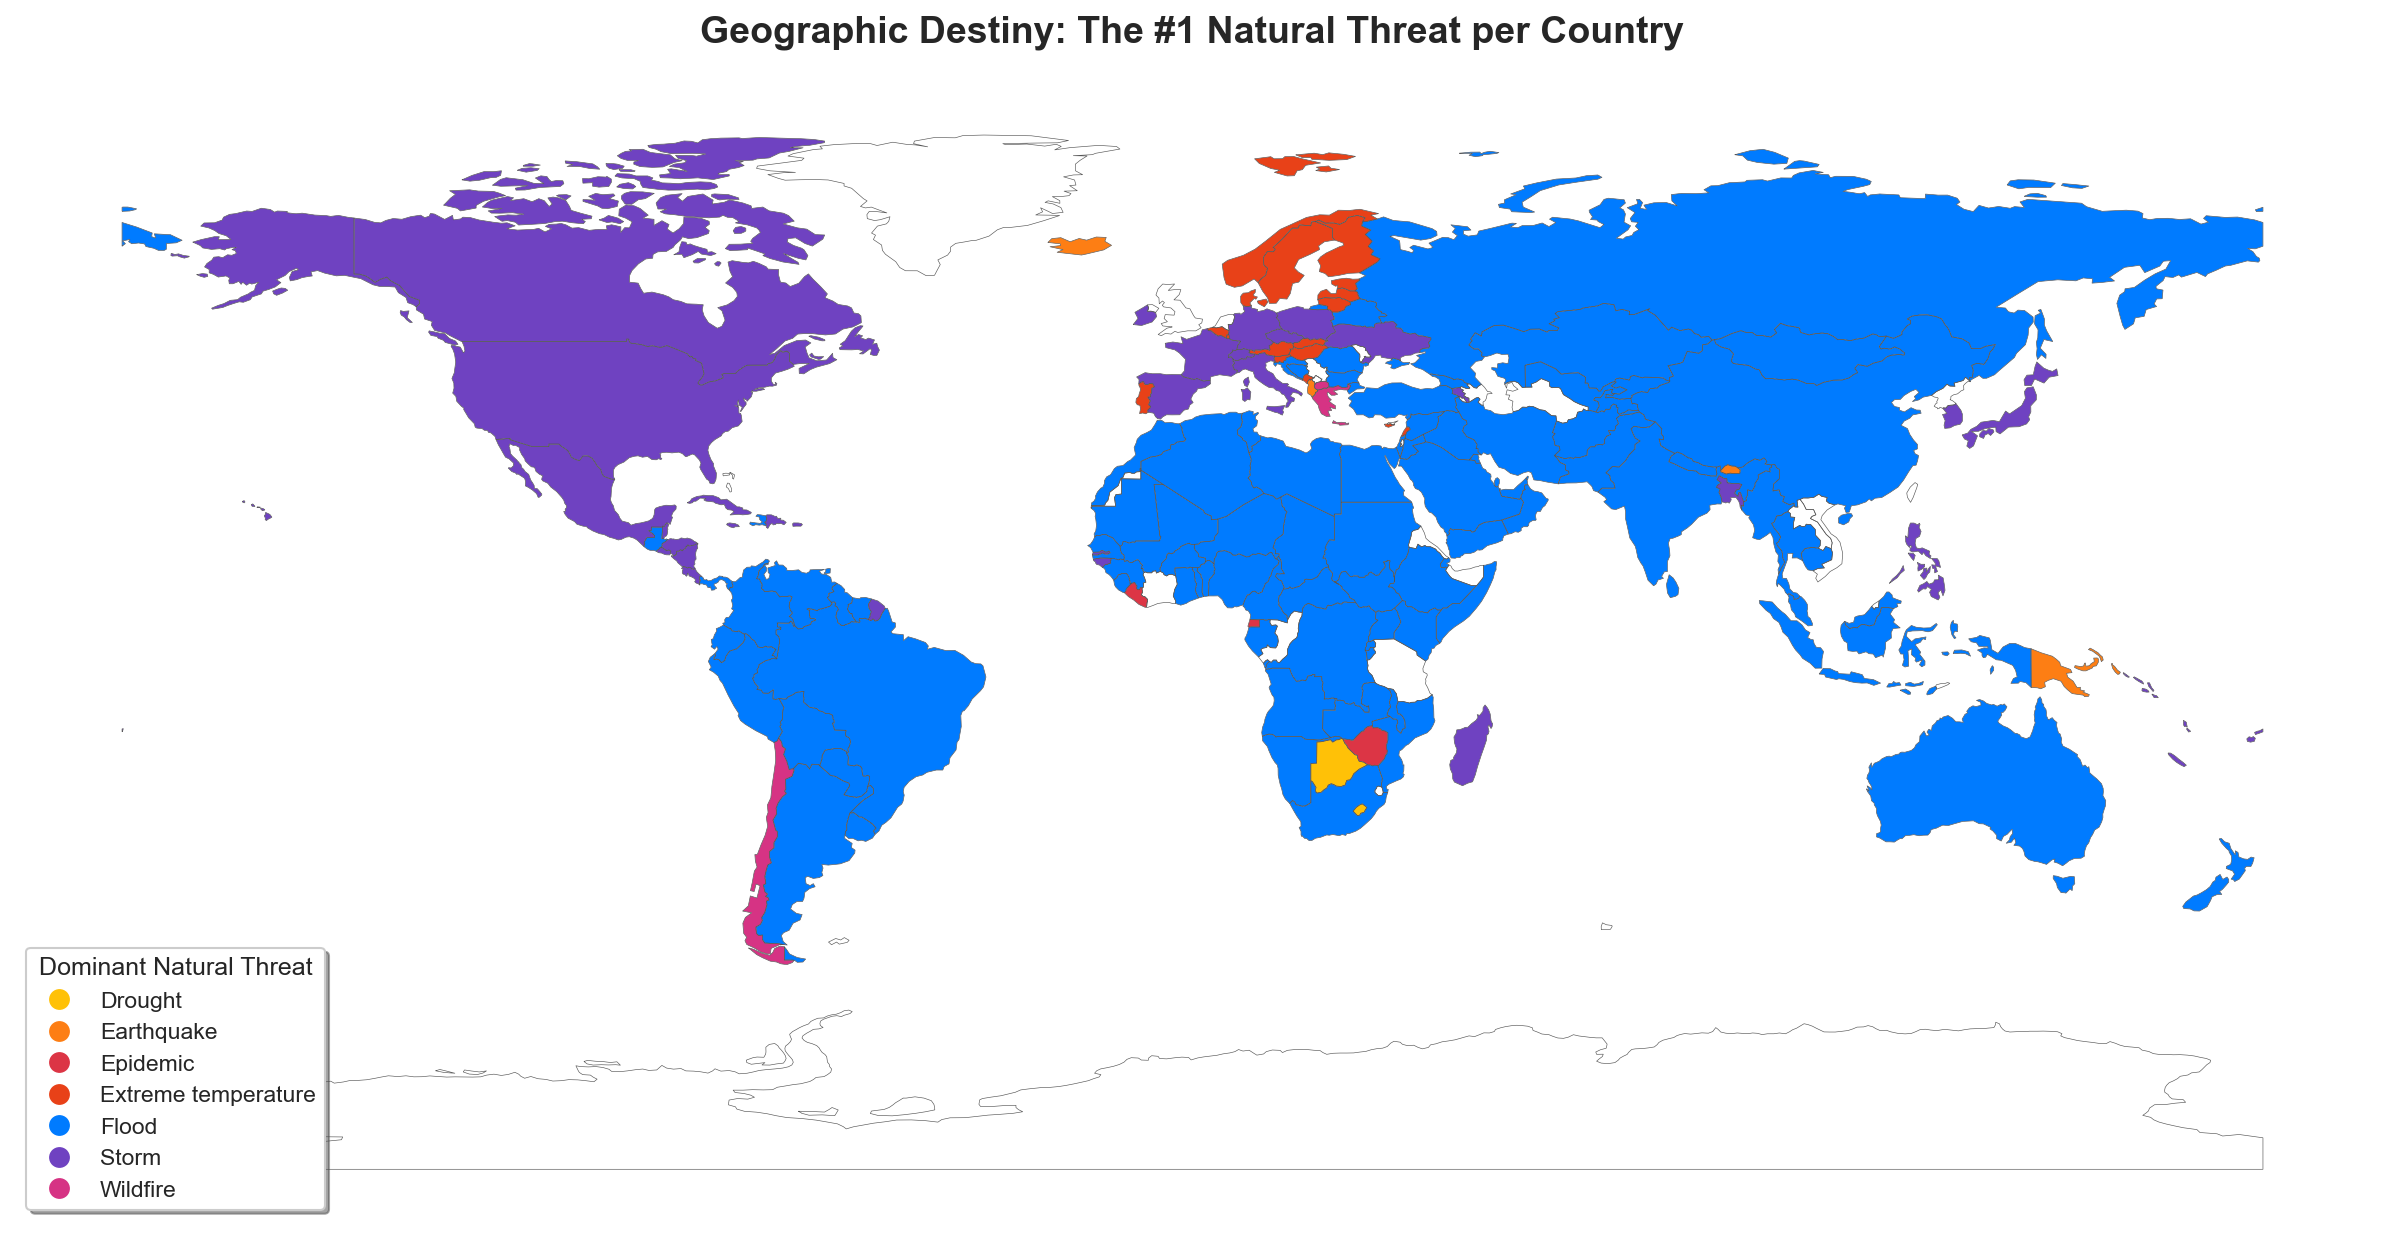

In [5]:
# =================================================
# 5. PRIMARY NATURAL HAZARD CLASSIFICATION BY REGION
# =================================================
# Determine the most frequent natural disaster category for each country,
# revealing geographical risk patterns (e.g., Flood belt vs. Seismic zones).
# Note: Analysis is strictly limited to natural events to isolate environmental risks.

# 1. NATURAL DISASTER WHITELIST
valid_natural_types = [
    'Flood', 'Storm', 'Earthquake', 'Drought', 'Landslide', 
    'Wildfire', 'Extreme temperature', 'Volcanic activity', 
    'Epidemic', 'Insect infestation', 'Mass movement (dry)', 'Impact'
]

# Filter to keep only these types
df_natural = df[df['disaster_type'].isin(valid_natural_types)].copy()

# 2. Find Dominant Natural Type per Country
dominant_disaster = df_natural.groupby(['country_mapped', 'disaster_type']).size().reset_index(name='count')
dominant_disaster = dominant_disaster.loc[dominant_disaster.groupby('country_mapped')['count'].idxmax()]

# Merge with Map
world_dom = world.merge(dominant_disaster, left_on='name', right_on='country_mapped', how='left')
world_dom = world_dom.dropna(subset=['disaster_type'])

# 3. Color Palette (Blue = Flood)
color_dict = {
    'Flood': '#007bff',       # Bright Blue
    'Storm': '#6f42c1',       # Purple
    'Earthquake': '#fd7e14',  # Orange
    'Drought': '#ffc107',     # Yellow
    'Epidemic': '#dc3545',    # Red
    'Landslide': '#795548',   # Brown
    'Wildfire': '#d63384',    # Pink/Red
    'Extreme temperature': '#e84118', # Dark Red
    'Volcanic activity': '#2c3e50',   # Dark Grey
    'Insect infestation': '#2ecc71',  # Green
    'Mass movement (dry)': '#A0522D'  # Earthy Brown
}

# Create Colormap
unique_types = sorted(world_dom['disaster_type'].unique())
final_colors = []
fallback_palette = sns.color_palette("bright", len(unique_types)).as_hex()

for i, dtype in enumerate(unique_types):
    if dtype in color_dict:
        final_colors.append(color_dict[dtype])
    else:
        final_colors.append(fallback_palette[i])

custom_cmap = ListedColormap(final_colors)

# 4. Visualization
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# LAYER 1: Color Fill
world_dom.plot(column='disaster_type', ax=ax, legend=True,
               categorical=True, 
               cmap=custom_cmap, 
               edgecolor='white', linewidth=0.1, # Pixel-free look
               legend_kwds={'loc': 'lower left', 'title': 'Dominant Natural Threat', 
                            'fontsize': 11, 'title_fontsize': 12, 'frameon': True, 'shadow': True},
               missing_kwds={'color': '#f8f9fa'}) 

# LAYER 2: Country Borders
world.boundary.plot(ax=ax, linewidth=0.3, color='#555555', zorder=2)

ax.set_title("Geographic Destiny: The #1 Natural Threat per Country", fontsize=18, fontweight='bold', pad=20)
ax.set_axis_off()

plt.tight_layout()
plt.savefig('../images/04_geospatial/geo_dominant_threats.png', dpi=300, bbox_inches='tight')
plt.show()